# Multiple Recommendation Systems

> **[Link](https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system/notebook)**

## Data gathering and peeking

In [1]:
import pandas as pd
import numpy as np
df1=pd.read_csv('/content/tmdb_5000_credits.csv')
df2=pd.read_csv('/content/tmdb_5000_movies.csv')

In [2]:
df1.columns = ['id','tittle','cast','crew']
df2= df2.merge(df1,on='id')

In [3]:
df2.iloc[0,:]

,0
budget,237000000
genres,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
homepage,http://www.avatarmovie.com/
id,19995
keywords,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":..."
original_language,en
original_title,Avatar
overview,"In the 22nd century, a paraplegic Marine is di..."
popularity,150.437577
production_companies,"[{""name"": ""Ingenious Film Partners"", ""id"": 289..."


## Demographic Filtering

They offer generalized recommendations to every user, based on movie popularity and/or genre. The System recommends the same movies to users with similar demographic features. Since each user is different , this approach is considered to be too simple. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.

We would use IMDB's weighted rating to score each movies, rather than using votes.

[Click for the image](https://image.ibb.co/jYWZp9/wr.png)

where,

 - v is the number of votes for the movie (We have this);
 - m is the minimum votes required to be listed in the chart;
 - R is the average rating of the movie (We have this); And
 - C is the mean vote across the whole report


In [4]:
C = df2["vote_average"].mean()
C # Mean rating out of 10

np.float64(6.092171559442016)

In [5]:
m = df2["vote_count"].quantile(0.9)
m # This many amount of votes required at least

np.float64(1838.4000000000015)

In [6]:
q_movie = df2.copy().loc[df2["vote_count"] >= m]
q_movie.shape

(481, 23)

In [7]:
def weighted_rating(X, m=m, C=C):
  v = X["vote_count"]
  R = X["vote_average"]
  return (v/(v+m) * R) + (m/(m+v) * C)

In [8]:
q_movie["score"] = q_movie.apply(weighted_rating, axis=1)

### These are Trending Now stuff !!!!

In [9]:
q_movie = q_movie.sort_values("score", ascending=False)
q_movie[['title', 'vote_count', 'vote_average', 'score', 'popularity']].head(10)

,title,vote_count,vote_average,score,popularity
1881,The Shawshank Redemption,8205,8.5,8.059258,136.747729
662,Fight Club,9413,8.3,7.939256,146.757391
65,The Dark Knight,12002,8.2,7.920020,187.322927
3232,Pulp Fiction,8428,8.3,7.904645,121.463076
96,Inception,13752,8.1,7.863239,167.583710
3337,The Godfather,5893,8.4,7.851236,143.659698
95,Interstellar,10867,8.1,7.809479,724.247784
809,Forrest Gump,7927,8.2,7.803188,138.133331
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243,123.630332
1990,The Empire Strikes Back,5879,8.2,7.697884,78.517830


Text(0.5, 1.0, 'Popular Movies')

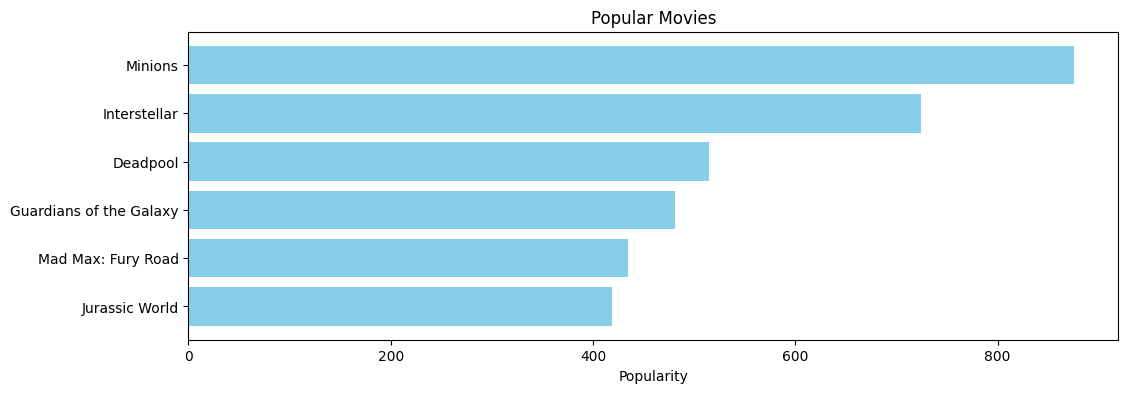

In [10]:
# Checking popularity
pop= df2.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

## Content Based Filtering

In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.

In [11]:
df2["overview"].head(1)[0]

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'

We will use TFIDF for converting Text to Vectors.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')

df2['overview'] = df2['overview'].fillna('')
tfidf_matrix = tfidf.fit_transform(df2['overview'])
tfidf_matrix.shape

(4803, 20978)

In [13]:
# We will get the cosine similarity of each movie with its similar movies
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [14]:
# It would create something like title - number (0-end)
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

 - Get the index of the movie given its title.
 - Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
 - Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
 - Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
 - Return the titles corresponding to the indices of the top elements.

In [15]:
def get_rec(title, cosine_sim=cosine_sim):
  idx = indices[title]
  sim_scores = list(enumerate(cosine_sim[idx])) # list of tuples (num, similarity)
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) # sorting based on similarity score
  sim_scores = sim_scores[1:11] # Top 10, 0th is self (ignored)
  movie_indices = [i[0] for i in sim_scores]

  return df2['title'].iloc[movie_indices] # Titles

In [16]:
get_rec("Inception")

,title
2897,Cypher
134,Mission: Impossible - Rogue Nation
1930,Stone Cold
914,Central Intelligence
1683,Pitch Perfect 2
1248,At First Sight
1512,A History of Violence
2389,Renaissance
1803,Blood and Wine
1267,Duplex


## Credits, Genres and Keywords Based Recommender

It goes without saying that the quality of our recommender would be increased with the usage of better metadata. That is exactly what we are going to do in this section. We are going to build a recommender based on the following metadata: the 3 top actors, the director, related genres and the movie plot keywords.

In [17]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

In [18]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
  for i in x:
    if i["job"] == "Director":
      return i["name"]
  return np.nan

# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
  if isinstance(x, list):
    names = [i["name"] for i in x]
    if len(names) > 3:
      names = names[:3]
    return names
  return []

In [19]:
df2['director'] = df2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)

In [20]:
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [21]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

In [22]:
# our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)

In [23]:
# We use the CountVectorizer() instead of TF-IDF. This is because we do not want to down-weight
  # the presence of an actor/director if he or she has acted or directed in relatively more movies.
from sklearn.feature_extraction.text import CountVectorizer # Creates count of tokens in all of corpus

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

In [24]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [25]:
# Reset index of our main DataFrame and construct reverse mapping as before
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['title'])

In [26]:
# BETTER recommendation.
get_rec("Interstellar", cosine_sim2)

,title
270,The Martian
2375,Midnight Special
363,A.I. Artificial Intelligence
1446,The Tree of Life
2752,Ex Machina
3043,End of the Spear
3373,The Other Side of Heaven
3624,Moon
39,TRON: Legacy
43,Terminator Salvation


## Collaborative Filtering

Our **content-based recommender** has two fundamental limitations:

1. It can only recommend movies **similar to a given movie**, not across a user’s broader taste space.
2. It is **not personalized** — every user querying the same movie gets identical recommendations, regardless of personal bias or taste.

To overcome this, we use **Collaborative Filtering (CF)**, which leverages the collective behavior of users.

CF is broadly divided into two types:

---

### 1. User-Based Collaborative Filtering

User-based CF recommends movies to a target user based on **what similar users liked**.

* Each row represents a user
* Each column represents a movie
* Ratings capture user preferences

To identify similar users, we compute similarity using:

* **Pearson Correlation** (captures relative preference patterns, handles rating bias)
* **Cosine Similarity** (captures raw rating similarity, sensitive to scale)

**Key idea:**
Similarity measures *taste alignment*, not movie content.

Users with **no overlapping rated movies** cannot be compared using Pearson correlation and are ignored.

A **negative Pearson correlation** indicates opposing preferences — such users should *not* influence recommendations.

Once similar users are identified, we predict missing ratings for the target user by aggregating ratings from their most similar neighbors.

**Limitations:**

* User preferences change over time
* Precomputed user similarity matrices become stale
* Poor scalability for large user bases

---

### 2. Item-Based Collaborative Filtering

Item-based CF recommends movies based on **similarity between items**, rather than users.

* Similarity is computed between movies
* Recommendations are based on movies the user has already rated
* Similarity can again be computed using Pearson or Cosine

**Key difference:**

* User-based CF fills missing ratings **horizontally (across users)**
* Item-based CF fills missing ratings **vertically (across items)**

**Advantages:**

* More stable over time (items change less than users)
* Better suited for large-scale systems

**Limitations:**

* **Scalability:** similarity computation grows with both users and items (worst-case (O(mn)))
* **Sparsity:**
  Two movies may appear highly similar simply because a very small number of users rated both

In extreme sparse cases, similarity scores can be **misleadingly high**.

---

### Takeaway

* User-based CF → better at modeling **personal taste**, but unstable and less scalable
* Item-based CF → more **stable and scalable**, but vulnerable to sparsity artifacts

Modern systems often combine CF with **content-based signals or embeddings** to mitigate these issues.

### Singular Value Decomposition (SVD)

Collaborative Filtering suffers from **sparsity** and **poor scalability**.
Latent factor models address this by representing users and items in a **shared low-dimensional space**.

SVD factorizes the user–item rating matrix into latent factors that capture **hidden preferences** (e.g., taste, style, genre affinity).

Each user and item is mapped to an (r)-dimensional vector, making them directly comparable.
Predicted ratings are obtained by optimizing for **minimum prediction error**, commonly measured using **RMSE**.

Lower RMSE ⇒ better recommendation quality.

This approach scales better than memory-based CF and generalizes well even with sparse data.

In the following section, we use the **Surprise** library to implement SVD on a dataset with explicit `userId`s.

**Cant run this! Issues between surprise and numpy**

In [ ]:
!pip install -q scikit-surprise
from surprise import Reader, Dataset, SVD, evaluate

In [ ]:
reader = Reader()
ratings = pd.read_csv('/content/ratings_small.csv')
ratings.head()

In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data.split(n_folds=5)

svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
ratings[ratings['userId'] == 1]

In [ ]:
svd.predict(1, 302, 3)

```Prediction(uid=1, iid=302, r_ui=3, est=2.5773468910098756, details={'was_impossible': False})```
For movie with ID 302, we get an estimated prediction of 2.618. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.